<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos-pan-eu-cost.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 2: Retrieval of traits from spectral data

**Authors:**
Egor Prikaziuk (e.prikaziuk@utwente.nl)

# Learning objectives

**After follwing this notebook you will be able to ...**
- propagate uncertainty in the satellite reflectance to uncertainty in retrieved traits (fAPAR)


# TOC

1. [Retrieval theory](#1)
2. [Sentinel-2](#2)
3. [Propagate uncertainty](#3)
    1. [3-1](#3-1) Monte Carlo sampler initialization
    2. [3-2](#3-2) model function definition
    3. [3-3](#3-3) mean value computation
    4. [3-4](#3-4) uncertainty definition
    5. [3-5](#3-5) uncertinaty propagation
4. [Plot](#4)
5. [Export](#5) 

# 1

## Retrieval
[back to TOC](#TOC)

Retrieval is extraction of information from reflectance data.

There are three main groups of retrieval methods ([Verrelst et al., 2019](https://doi.org/10.1007/s10712-018-9478-y)):
1. Regression-based
2. Radiative transfer model (RTM)-based
3. Hybrid

This notebook demonstrates uncertainty propagation through a **regresson-based method**, when a key driver of photosynthesis, the fraction of absorbed photosynthetically active radiation (fAPAR), is retrieved from the normalized difference vegetation index (NDVI).

Uncertainty propagation through an **RTM-based retrieval** is described by `Jose Gomez-Dans` in a paired GitHub repository [09-PiccoloDoppioInversion.ipynb](https://github.com/pangeos-cost/pangeos_uq/blob/main/notebooks/09-PiccoloDoppioInversion.ipynb)

The so-called epistemic uncertainty propagation through the **hybrid inversion** methods in the [ARTMO toolbox](https://artmotoolbox.com/) is discussed by `Jose Luis Garcia-Soria` 

<span style="color:red">
Here comes the link to Jose's presentation
</span>

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import punpy

from pathlib import Path

plt.rcParams.update({'font.size': 16})

# 2
## Sentinel-2
[back to TOC](#TOC)

Let's take for this case time-series of NDVI from Sentinel-2 to see how the uncertainty evolves temporally

The data is a single pixel in the middle of a vegetaion field, extracted from the Google Earth Engine Sentinel-2 Level-2 (atmospherically corrected) collection https://code.earthengine.google.com/e5877b18d7229acf0ee9f15542a4a20f

In [2]:
df = pd.read_csv('../data/s2-pixelTs.csv', index_col='date', parse_dates=True)
df = df[~df.index.duplicated(keep='first')]
df.head()

,system:index,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,SCL,sun_azimuth,sun_zenith,view_azimuth_mean,view_zenith_mean,.geo
date,,,,,,,,,,,,,,,,,,,
2023-02-26,20230226T103919_20230226T104451_T31UGT,0.1323,0.3142,0.2158,0.1396,0.1725,0.1412,0.2141,0.4750,0.5559,0.6357,0.5703,0.5419,4.0,163.286675,61.867603,163.497566,3.120753,"{""type"":""Point"",""coordinates"":[6.8616,52.23420..."
2023-03-03,20230303T103931_20230303T104046_T31UGT,0.2598,0.4014,0.3124,0.2335,0.2533,0.2370,0.2968,0.4755,0.5207,0.5482,0.5374,0.5250,5.0,163.140426,59.964811,163.598921,3.133224,"{""type"":""Point"",""coordinates"":[6.8616,52.23420..."
2023-03-23,20230323T103711_20230323T103711_T31UGT,0.1322,0.2870,0.1886,0.1280,0.1609,0.1264,0.2011,0.5108,0.6040,0.6177,0.6137,0.5618,4.0,163.012744,52.006320,164.224799,3.122854,"{""type"":""Point"",""coordinates"":[6.8616,52.23420..."
2023-04-02,20230402T103621_20230402T104404_T31UGT,0.1361,0.2416,0.2031,0.1382,0.1562,0.1562,0.1893,0.2400,0.2506,0.2646,0.2619,0.2640,5.0,163.054866,48.031188,163.904626,3.125642,"{""type"":""Point"",""coordinates"":[6.8616,52.23420..."
2023-05-17,20230517T103629_20230517T103641_T31UGT,0.1705,0.3584,0.3660,0.1922,0.1964,0.2212,0.2309,0.2476,0.2591,0.2799,0.2868,0.3225,5.0,161.469922,33.548516,165.127408,3.114572,"{""type"":""Point"",""coordinates"":[6.8616,52.23420..."


# 3
## propagation of uncertainty
[back to TOC](#TOC)

Same steps as in the previous notebooks
1. [3-1](#3-1) Monte Carlo sampler initialization
2. [3-2](#3-2) model function definition
3. [3-3](#3-3) mean value computation
4. [3-4](#3-4) uncertainty definition
5. [3-5](#3-5) uncertinaty propagation

### 3-1 
#### Monte Carlo sampler initialization

In [3]:
prop = punpy.MCPropagation(10000)

### 3-2
#### function definition of fAPAR computation
[back to TOC](#TOC)

There are numerous formula that relate NDVI and fAPAR linearly. We will use [Myneni and Williams (1994)](https://doi.org/10.1016/0034-4257(94)90016-7) caption of figure 11

$fAPAR = 1.1638 \cdot NDVI -0.1426 $

In [4]:
def clc_fapar(red, nir, slope=1.1638, intercept=-0.1426):
    """
    Myneni and Williams, 1994, caption of figure 11 https://doi.org/10.1016/0034-4257(94)90016-7
    """
    ndvi = (nir - red) / (nir + red)
    
    fapar = slope * ndvi + intercept
    fapar = np.clip(fapar, 0, 1)
    
    return fapar

### 3-3
#### mean value computation
[back to TOC](#TOC)

In [5]:
r_red = df.B4.values
r_nir = df.B8.values
fapar = clc_fapar(r_red, r_nir)

### 3-4 
#### uncertainty quantification
[back to TOC](#TOC)

There are various sources of uncertainty related to satellite imagery; to name a few
- radiometric calibration (similar to Piccolo)
- georeferencing
- atmospheric correction
  
An extra case illustrating the **uncertainty of the atmospheric** correction is presented in a separate [PyEOSim repository](https://github.com/pangeos-cost/pangeos-training-24) by `Joe Fennell`

In the near future satellite imagery will be distributed together with uncertainty estimates (is is already so for [some Sentinel-3 products](https://senbox.atlassian.net/wiki/spaces/SIIITBX/pages/3997702/Sentinel-3+Toolbox+-+Quickstart) *"Several of the Sentinel-3 products contain bands with assigned error or uncertainty bands"*. Therefore, it is important to know how to propagate uncertainties further to computed products.

In this notebook we will assume some uncertainties of band reflectance, as if they are given by the producer. In the Piccolo case total relative uncertainty or reflectance was around 4%. We can add at least 1% more for the atomspheric correction uncertainty.

In [6]:
u_rel = 0.05  # 5%
u_red = r_red * u_rel
u_nir = r_nir * u_rel

### 3-5
#### uncertainty propagation
[back to TOC](#TOC)

function help https://punpy.readthedocs.io/en/latest/content/generated/punpy.mc.mc_propagation.MCPropagation.propagate_random.html#punpy.mc.mc_propagation.MCPropagation.propagate_random

In [7]:
fapar_ur = prop.propagate_random(clc_fapar, 
                                  [r_red, r_nir],
                                  [u_red, u_nir])
fapar_ur

array([0.02449491, 0.03440124, 0.02304678, 0.03860011, 0.0220054 ,
       0.03123814, 0.03592144, 0.0396273 , 0.03789573, 0.03503124,
       0.02986258, 0.02808174, 0.02721547, 0.02590805, 0.02732111,
       0.02770854, 0.0278815 , 0.02968851, 0.03519662, 0.0374127 ,
       0.03814787])

# 4
## Plotting
[back to TOC](#TOC)

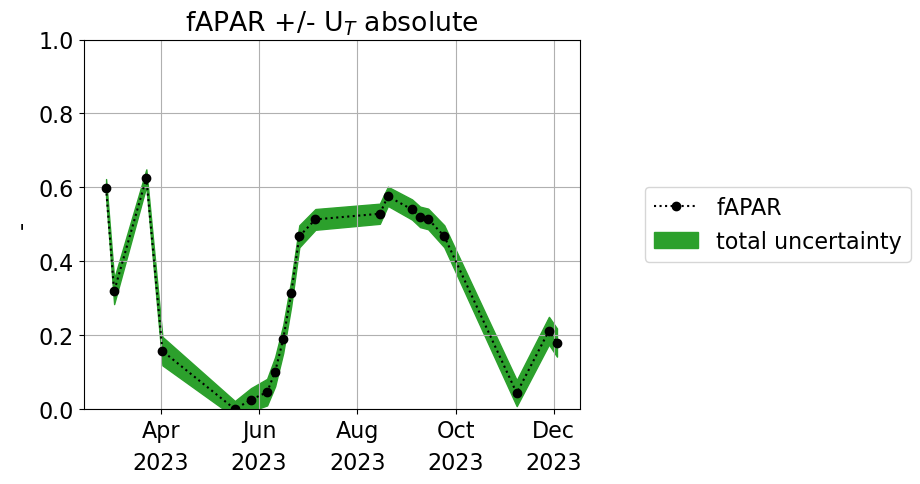

In [9]:
ax = plt.subplot()

x = df.index
y = fapar
ur = fapar_ur
c = 'tab:green'
utype = 'total'

ax.plot(x, y, color="black", marker='o', linestyle=':', label='fAPAR')
ax.fill_between(x, y - ur, y + ur, color=c, alpha=1, label=f"{utype} uncertainty")

# ax.twinx().plot(x, ur / y * 100, color="green", marker='o', linestyle=':', label='fAPAR relative uncertainty')

ax.set_title("fAPAR +/- U$_T$ absolute")
ax.set_ylabel('-')
ax.set_ylim([0, 1])
ax.legend(loc='center', bbox_to_anchor=(1.4, 0.5))
ax.grid()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0)

### relative uncertainty

C:\Users\PrikaziukE\AppData\Local\Temp\ipykernel_9388\683485485.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.plot(x, ur / y * 100, color="green", marker='o', linestyle=':', label='fAPAR relative uncertainty')


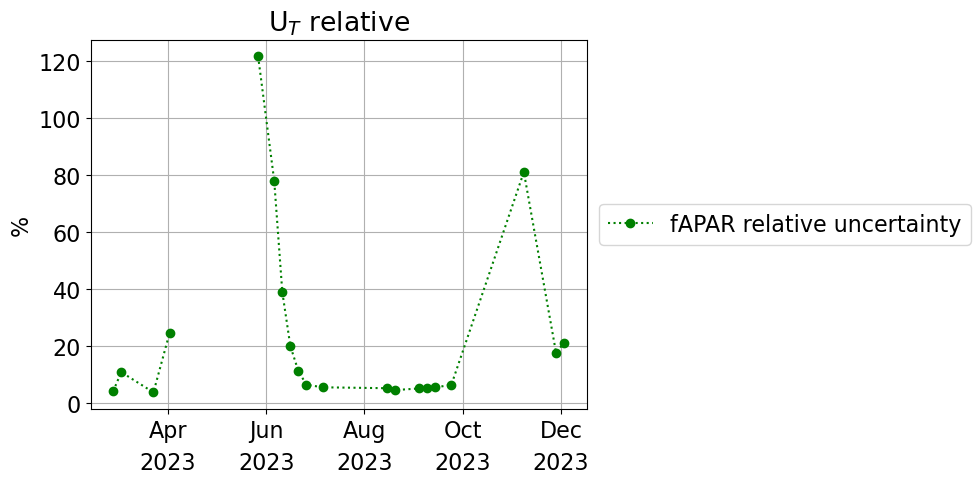

In [10]:
ax = plt.subplot()

x = df.index
y = fapar
ur = fapar_ur
c = 'tab:green'
utype = 'total'

ax.plot(x, ur / y * 100, color="green", marker='o', linestyle=':', label='fAPAR relative uncertainty')

ax.set_title("U$_T$ relative")
ax.set_ylabel('%')
# ax.set_ylim([0, 1])
ax.legend(loc='center', bbox_to_anchor=(1.4, 0.5))
ax.grid()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0)

# 5
## Export
[back to TOC](#TOC)

saving results for case 3 - model runs

In [11]:
df['fapar'] = fapar
df['fapar_u'] = fapar_ur

# df[['fapar', 'fapar_u']].to_csv('../data/s2-fapar-ts.csv')

<span style="color:red">
Think. How would you propagate the spatial uncertainty through the spatial averaging over the whole field (e.g. with a shape file)?
</span>